# Testing HW equilibrium


In [8]:
library(data.table)
library(lfa)
library(ggplot2)

output_path = "../output/data/"


## Generation 0 (baseline)

In [42]:
# read data
dat = fread(paste0(output_path, "agents-snp-hw.csv"))
# create id
dat[, id := .GRP, .(iteration, replicate)]
# snp text to numeric
vars = paste0("snp", 1:100)
dat[, (vars) := tstrsplit(snps, ",", fixed=TRUE), id]
dat[, (vars) := lapply(.SD, function(x) as.numeric(gsub(".+=|\\}", "", x))), .SDcols = vars]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    23.0    45.5    45.5    68.0    90.0 

In [47]:
# compute p-values
pvalues = NULL
for (i in 1:90) {
    # print(paste0("::::::: replicate ", i))
    temp = copy(dat[id == 1])
    m = as.matrix(transpose(temp[, .SD, .SDcols = names(temp) %like% "snp[0-9]+"]))
    # using k=1 for standard HW test
    LF = lfa(m, 1)
    pvalues = c(pvalues, sHWE(m, LF, 4))
}
summary(pvalues)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2844  0.5600  0.5373  0.7731  1.0000 

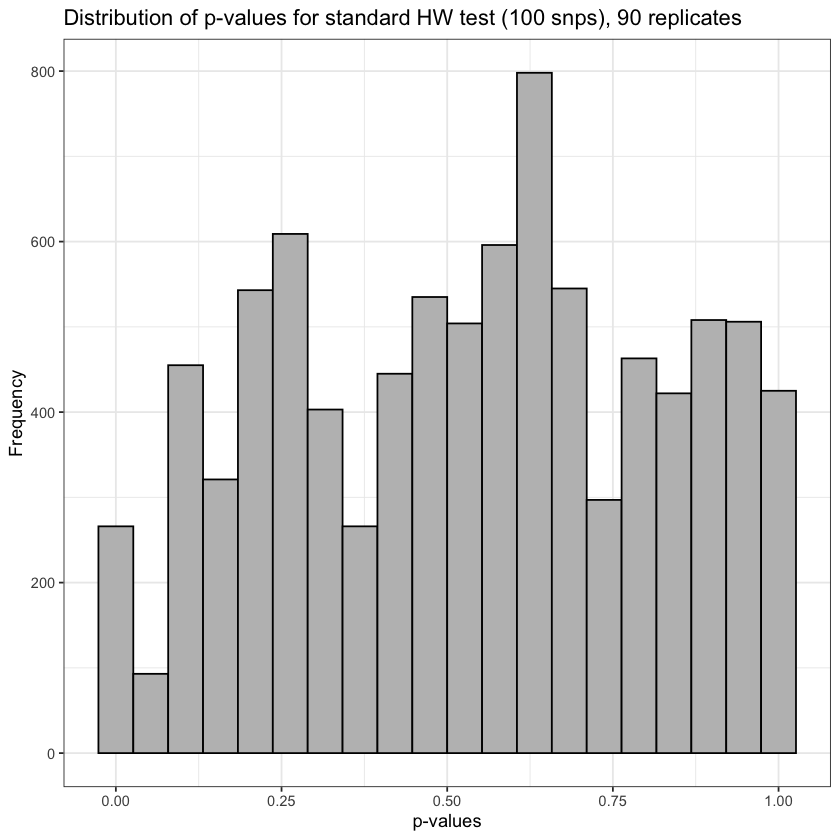

In [48]:
# plot with distribution of p-values
ggplot() + aes(pvalues)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps), 90 replicates")
